# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [7]:
from kan import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
#model = KAN(width=[2,[2,1],1], grid=100, k=3, device=device)
model = KAN(width=[2,[5,5],1], grid=100, k=3, device=device)

# create dataset
a = 1
b = 1
f = lambda x: 1 - ((x[:,[0]]**2)/a**2) - ((x[:,[1]]**2)/b**2) - ((x[:,[0]]*x[:,[1]])/(a*b))
dataset = create_dataset(f, n_var=2, ranges=[-100, 100], device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


Train KAN (grid=3)

In [8]:
model.fit(dataset, opt="LBFGS", steps=500);

description:   0%|                                                          | 0/500 [00:00<?, ?it/s]

| train_loss: 1.53e+03 | test_loss: 1.62e+04 | reg: 3.21e+02 | : 100%|█| 500/500 [02:13<00:00,  3.76

saving model version 0.1


The loss plateaus. we want a more fine-grained KAN!

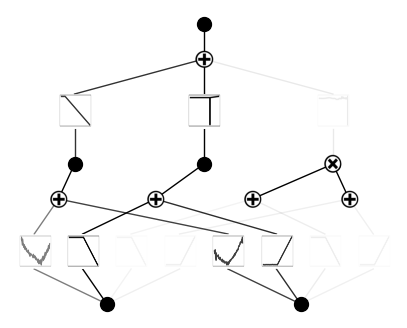

In [9]:
model.plot()

In [ ]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

Train KAN (grid=10)

In [ ]:

model.fit(dataset, opt="LBFGS", steps=20, update_grid=False);

The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [ ]:
model.plot()

In [10]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

tensor(2336827.5000, grad_fn=<MeanBackward0>)

In [ ]:
grids = np.array([3,10,20,50,100])


train_losses = []
test_losses = []
steps = 200
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,[2,1],1], grid=grids[i], k=k, seed=1, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

In [ ]:
results = model.fit(dataset, opt="LBFGS", steps=1e4, update_grid=False)

In [ ]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws (For some reason, this got worse than pykan 0.0. We're still investigating the reason, probably due to the updates of curve2coef)

In [ ]:
x_trial = torch.tensor([[1. % 2*np.pi,1000.0]], device=device)
print(model(x_trial))
print(f(x_trial))

In [ ]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

In [ ]:
model.plot()

In [ ]:
model.prune(node_th=1e-1, edge_th=0.1)
model.plot()

In [ ]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)